Spooky Author Identification
=============

Data Exploration
------------

This notebook will be used to import the data files, explore the style of each spooky author using different statistics of sentences, and fit models like Logistic Regression, XGBoost etc. using these sentence statistics as  features.

In [2]:
# All the modules that will be used later
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk import FreqDist
import string
from sklearn.linear_model import LogisticRegression
from sklearn import model_selection
from sklearn import metrics
import xgboost as xgb
import itertools

First, let's read the train set and test set.

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
print('Train data size: ', train.shape)
print('Test data size: ', test.shape)

Train data size:  (19579, 3)
Test data size:  (8392, 2)


In [4]:
train.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


Let's check whether the classes are balanced in train dataset - whether the number of train examples of each author is close.

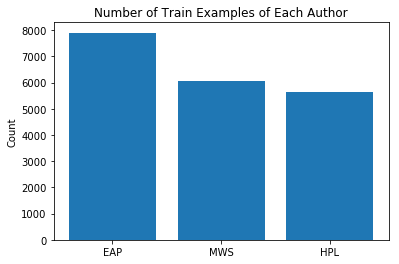

In [5]:
authors = train['author'].value_counts()
x_pos = np.arange(len(authors))
plt.figure()
plt.bar(x_pos, authors.values, align = 'center')
plt.xticks(x_pos, authors.index)
plt.ylabel('Count')
plt.title('Number of Train Examples of Each Author')
plt.show()

The classes look quite balanced in the train dataset.

Features
------------

Then, let's calculate some sentence statistics to explore the writing style of each author. The sentence statistics include:

- Number of words
- Number of unique words in the sentence
- Number of stop words in the sentence
- Number of punctuations in the sentence
- Number of nouns in the sentence
- Number of verbs in the sentence
- Average word length

In below statistics, punctuations are treated as words when calculating sentence length.

In [6]:
# Function to plot the distribution of sentence statistics
def plot_distribution(sentence_stat, xlim, xlabel):
    p = sns.kdeplot(train[sentence_stat].loc[train['author'] == 'EAP'], shade = True, color = 'r')
    p = sns.kdeplot(train[sentence_stat].loc[train['author'] == 'HPL'], shade = True, color = 'b')
    p = sns.kdeplot(train[sentence_stat].loc[train['author'] == 'MWS'], shade = True, color = 'y')
    p.set(xlabel = xlabel, xlim = xlim)
    p.legend(labels = ['EAP', 'HPL', 'MWS'])
    plt.show()

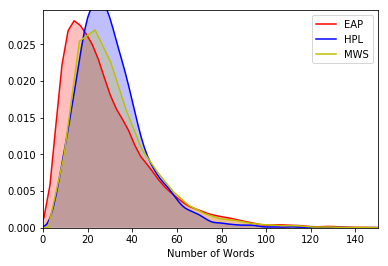

In [7]:
train['length'] = train['text'].apply(lambda t: len(word_tokenize(t)))
test['length'] = test['text'].apply(lambda t: len(word_tokenize(t)))
plot_distribution(sentence_stat = 'length', xlim = (0, 150), xlabel = 'Number of Words')

Seems that EAP tended to write in shorter sentences while HPL tended to write in longer ones. Then let's look at the number of unique words in the sentences.

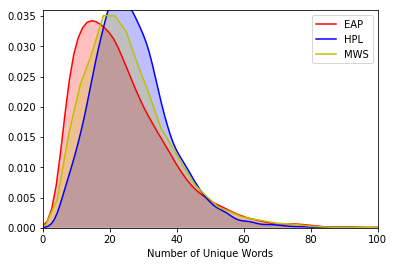

In [8]:
train['unique'] = train['text'].apply(lambda t: len(np.unique(word_tokenize(t))))
test['unique'] = test['text'].apply(lambda t: len(np.unique(word_tokenize(t))))
plot_distribution(sentence_stat = 'unique', xlim = (0, 100), xlabel = 'Number of Unique Words')

The trend is quite similar to sentence length. Then let's look at the number of stop words in the sentence.

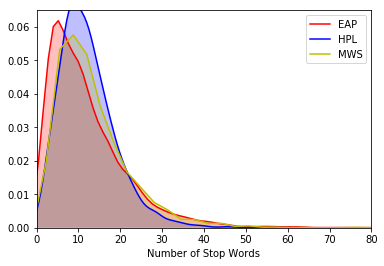

In [9]:
def count_stop_word(text):
    return len([w for w in word_tokenize(text) if w in stopwords.words('english')])

train['stop'] = train['text'].apply(lambda t: count_stop_word(t))
test['stop'] = test['text'].apply(lambda t: count_stop_word(t))
plot_distribution(sentence_stat = 'stop', xlim = (0, 80), xlabel = 'Number of Stop Words')

Seems that HPL tended to use more stop words than EAP and MWS. Then let's look at the number of punctuations in the sentence.

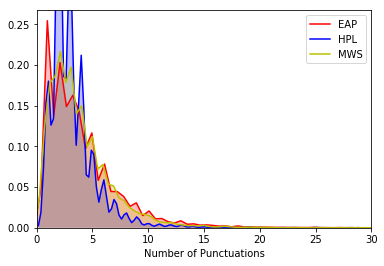

In [10]:
def count_punctuation(text):
    return len([c for c in text if c in string.punctuation])

train['punctuation'] = train['text'].apply(lambda t: count_punctuation(t))
test['punctuation'] = test['text'].apply(lambda t: count_punctuation(t))
plot_distribution(sentence_stat = 'punctuation', xlim = (0, 30), xlabel = 'Number of Punctuations')

Similar to stop words, seems that HPL tended to use more punctuations than EAP and MWS. Then let's look at the number of nouns and verbs in the sentence.

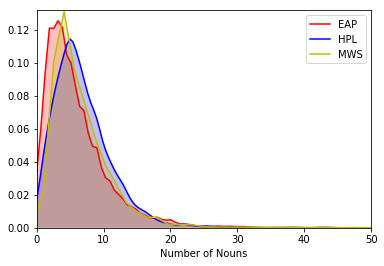

In [11]:
def count_noun(text):
    freq = FreqDist(tag for (word, tag) in pos_tag(word_tokenize(text)))
    noun_num = sum(num for tag, num in freq.items() if tag in ['NN', 'NNP', 'NNS'])
    return noun_num

train['noun'] = train['text'].apply(lambda t: count_noun(t))
test['noun'] = test['text'].apply(lambda t: count_noun(t))
plot_distribution(sentence_stat = 'noun', xlim = (0, 50), xlabel = 'Number of Nouns')

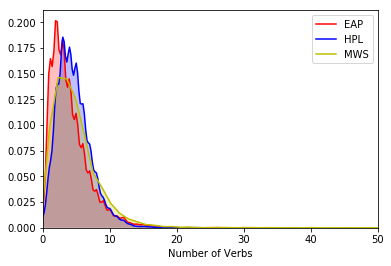

In [12]:
def count_verb(text):
    freq = FreqDist(tag for (word, tag) in pos_tag(word_tokenize(text)))
    verb_num = sum(num for tag, num in freq.items() if tag in ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ'])
    return verb_num

train['verb'] = train['text'].apply(lambda t: count_verb(t))
test['verb'] = test['text'].apply(lambda t: count_verb(t))
plot_distribution(sentence_stat = 'verb', xlim = (0, 50), xlabel = 'Number of Verbs')

Seems that HPL used more verbs than EAP and MWS. Then let's look at the average length of words each author used.

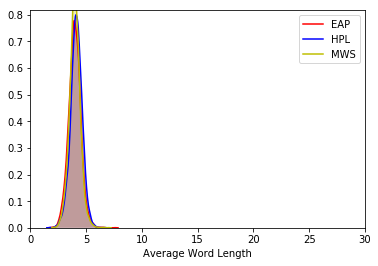

In [13]:
def avg_word_len(text):
    return np.mean([len(w) for w in word_tokenize(text)])

train['avg_word_len'] = train['text'].apply(lambda t: avg_word_len(t))
test['avg_word_len'] = test['text'].apply(lambda t: avg_word_len(t))
plot_distribution(sentence_stat = 'avg_word_len', xlim = (0, 30), xlabel = 'Average Word Length')

There is no obvious difference between the three authors. Then let's save the features for future use.

In [14]:
train.to_csv('train_features.csv')
test.to_csv('test_features.csv')

Models
------------

Now let's fit two widely used machine learning models, Logistic Regression and XGBoost, using the sentence statistics just created to predict the spooky authors.

In [15]:
# Features
X = train.drop(['id', 'text', 'author'], axis = 1)
X.shape

(19579, 7)

In [16]:
# Class labels
author_mapping = {'EAP': 0, 'HPL': 1, 'MWS': 2}
y = train['author'].map(author_mapping)
y.shape

(19579,)

Let's first fit a very simple Logistic Regression model and check the cross-validation log-loss.

In [17]:
# Run a 10-fold cross-validation using train set
log_loss = []
kf = model_selection.KFold(n_splits = 10, shuffle = True, random_state = 1001)
for dev_idx, val_idx in kf.split(X):
    X_dev, X_val = X.iloc[dev_idx], X.iloc[val_idx]
    y_dev, y_val = y[dev_idx], y[val_idx]
    lr = LogisticRegression()
    lr.fit(X_dev, y_dev)
    y_pred = lr.predict_proba(X_val)
    log_loss.append(metrics.log_loss(y_val, y_pred))

print("Mean cross-validation log-loss", np.mean(log_loss))

Mean cross-validation log-loss 0.998952519535


The result is not that bad considering we are only using the sentence statistics to fit the model. Then let's fit XGBoost model using the same features.

In [18]:
def run_xgboost(X_train, y_train, X_val):
    param = {'silent': 1, 'eta': 0.1, 'max_depth': 3, 'subsample': 0.8, 'colsample_bytree': 0.5,
             'objective': 'multi:softprob', 'eval_metric': 'mlogloss', 'num_class': 3, 'seed': 1001}
    plst = param.items()
    num_round = 1000
    dtrain = xgb.DMatrix(X_train, label = y_train)
    model = xgb.train(plst, dtrain, num_round)
    dtest = xgb.DMatrix(X_val)
    y_pred = model.predict(dtest, ntree_limit = model.best_ntree_limit)
    return model, y_pred

In [19]:
# Run a 10-fold cross-validation using train set
log_loss = []
kf = model_selection.KFold(n_splits = 10, shuffle = True, random_state = 1001)
for train_idx, val_idx in kf.split(X):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]
    model, y_pred = run_xgboost(X_train, y_train, X_val)
    log_loss.append(metrics.log_loss(y_val, y_pred))

print("Mean cross-validation log-loss", np.mean(log_loss))

Mean cross-validation log-loss 0.984304888358


The result is slightly better than Logistic Regression. Let's plot the importance of each feature.

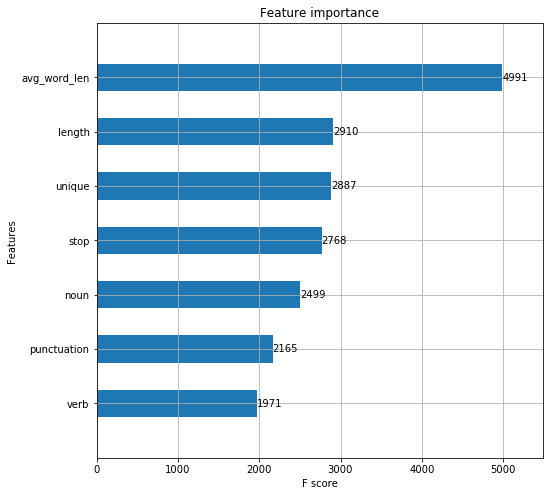

In [20]:
fig, ax = plt.subplots(figsize = (8, 8))
xgb.plot_importance(model, ax = ax, height = 0.5)
plt.show()

The average length of words each author used is the most important feature in differetiating the authors. Let's plot the confusion matrix and check which authors are the most confusing to the model.

Confusion matrix, without normalization
[[526 119 137]
 [177 295  94]
 [309 124 176]]


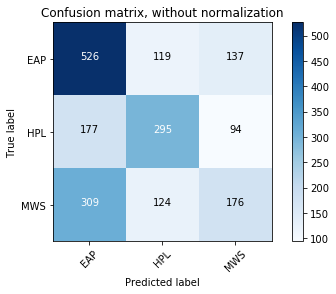

In [21]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = metrics.confusion_matrix(y_val, np.argmax(y_pred, axis = 1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['EAP', 'HPL', 'MWS'],
                      title='Confusion matrix, without normalization')

plt.show()

MWS is very prone to be misclassified as EAP by the current model. Now let's fit XGBoost model using all the train data and predict the authors for the test set.

In [22]:
# Features of test set
X_test = test.drop(['id', 'text'], axis = 1)
X_test.shape

(8392, 7)

In [23]:
model, test_prob = run_xgboost(X, y, X_test)

Then we merge the id and prediction of the test set and submit it to kaggle. The score is 0.98282, not that bad as we are only using very simple features.

In [24]:
sub_id = test['id'].values.reshape((len(test['id']), 1))
submission = np.concatenate((sub_id, test_prob), axis = 1)
submission = pd.DataFrame(submission, columns = ['id', 'EAP', 'HPL', 'MWS'])
submission.head()

,id,EAP,HPL,MWS
0,id02310,0.322725,0.294861,0.382414
1,id24541,0.364572,0.155954,0.479474
2,id00134,0.208421,0.571189,0.22039
3,id27757,0.484836,0.149344,0.36582
4,id04081,0.497321,0.181538,0.321141


In [25]:
submission.to_csv('submission.csv')

Reference
---------

[1] https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

[2] https://www.kaggle.com/sudalairajkumar/simple-feature-engg-notebook-spooky-author

[3] http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html